In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm import trange
from matplotlib import pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_data = EMNIST(root="root", download=True, split="balanced", train=True, transform=transform)
test_data = EMNIST(root="root", download=True, split="balanced", train=False, transform=transform)

class_names = train_data.classes
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size

train_data, val_data = random_split(train_data, [train_size, val_size])

print(f"len train data:{len(train_data)}")
print(f"len val data:{len(val_data)}")
print(f"len test data:{len(test_data)}")
print(f"class names:{class_names}")

100%|██████████| 562M/562M [00:04<00:00, 132MB/s]


len train data:90240
len val data:22560
len test data:18800
class names:['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [3]:
train_loader = DataLoader(train_data, batch_size=64)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

x, y = next(iter(train_loader))
print(f"train batch shape x:{x.shape}")
print(f"train batch shape y:{y.shape}")

train batch shape x:torch.Size([64, 1, 28, 28])
train batch shape y:torch.Size([64])


In [4]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
print(f"device: {device}")

device: cuda


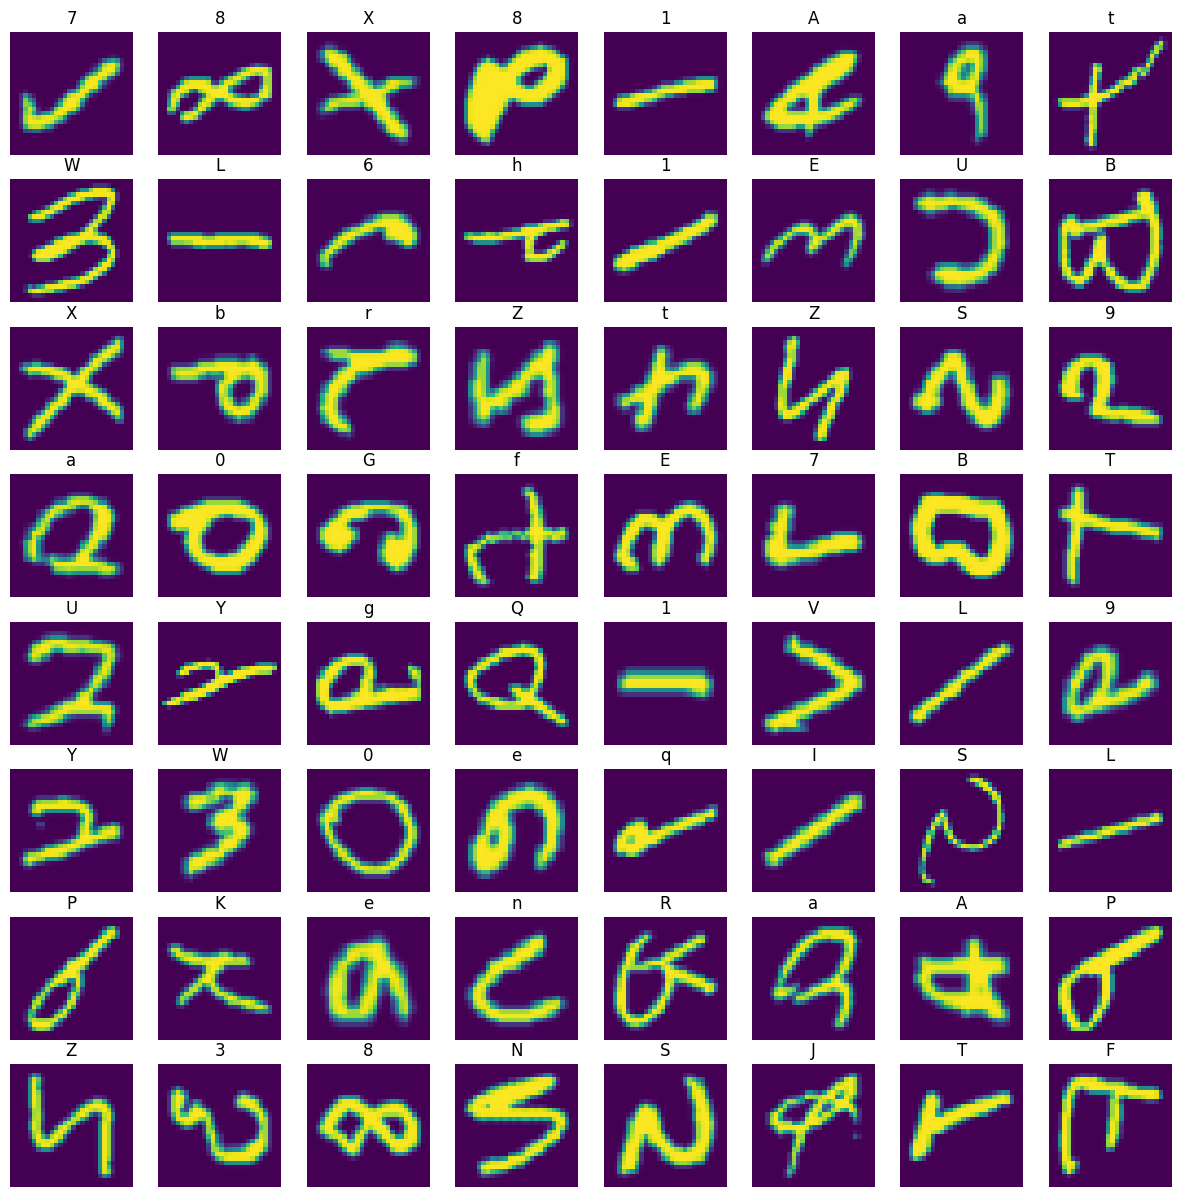

In [5]:
def visualize(character, label):
    fig, axe = plt.subplots(8, 8, figsize=(15, 15))
    for i, ax in enumerate(axe.flatten()):
        ax.imshow(character[i].squeeze())
        ax.set_title(class_names[label[i]])
        ax.axis("off")


visualize(x, y)

In [6]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.input_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.input_stack(x)


model = SimpleNN(input_size=28 * 28, num_classes=47)
model = model.to(device)
print(model)

SimpleNN(
  (input_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=47, bias=True)
  )
)


In [7]:
loss_nn = torch.nn.CrossEntropyLoss()
optimizer_nn = torch.optim.SGD(model.parameters(), lr=0.001)

In [8]:
def train(dataloader, model, loss_nn, optimizer_nn):
    model.train()
    size = len(dataloader.dataset)
    total_loss, correct = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_nn(pred, y)
        correct += (pred.argmax(1)==y).sum().item()
        total_loss += loss.item()
        optimizer_nn.zero_grad()
        loss.backward()
        optimizer_nn.step()

    return total_loss / len(dataloader), correct / size


In [9]:
def test(dataloader, model, loss_nn):
    model.eval()
    size = len(dataloader.dataset)
    total_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_nn(pred, y)
            correct += (pred.argmax(1)==y).sum().item()
            total_loss += loss.item()
    return total_loss / len(dataloader), correct / size

In [10]:
def evaluate(model, loss_nn, optimizer_nn, n_epoch):
    val_loss_list, val_acc_list = [], []
    train_loss_list, train_acc_list = [], []
    for epoch in (pbar := trange(n_epoch)):
        train_loss, train_acc = train(train_loader, model, loss_nn, optimizer_nn)
        val_loss, val_acc = test(val_loader, model, loss_nn)
        train_loss_list.append(train_loss), val_loss_list.append(val_loss)
        train_acc_list.append(train_acc), val_acc_list.append(val_acc)
        pbar.set_description(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f} | Train acc: {train_acc:.4f}, Val acc: {val_acc:.4f}")

    fig, axe = plt.subplots(1, 2, figsize=(15, 5))
    axe[0].plot(range(n_epoch), train_loss_list, label="train loss")
    axe[0].plot(range(n_epoch), val_loss_list, label="val loss")
    axe[0].set_xlabel("epoch"), axe[0].set_ylabel("loss")
    axe[0].legend()
    axe[1].plot(range(n_epoch), train_acc_list, label="train acc")
    axe[1].plot(range(n_epoch), val_acc_list, label="val acc")
    axe[1].set_xlabel("epoch"), axe[1].set_ylabel("acc")
    axe[1].legend()



Train loss: 1.4770, Val loss: 1.4553 | Train acc: 0.5824, Val acc: 0.5903: 100%|██████████| 20/20 [07:41<00:00, 23.10s/it]


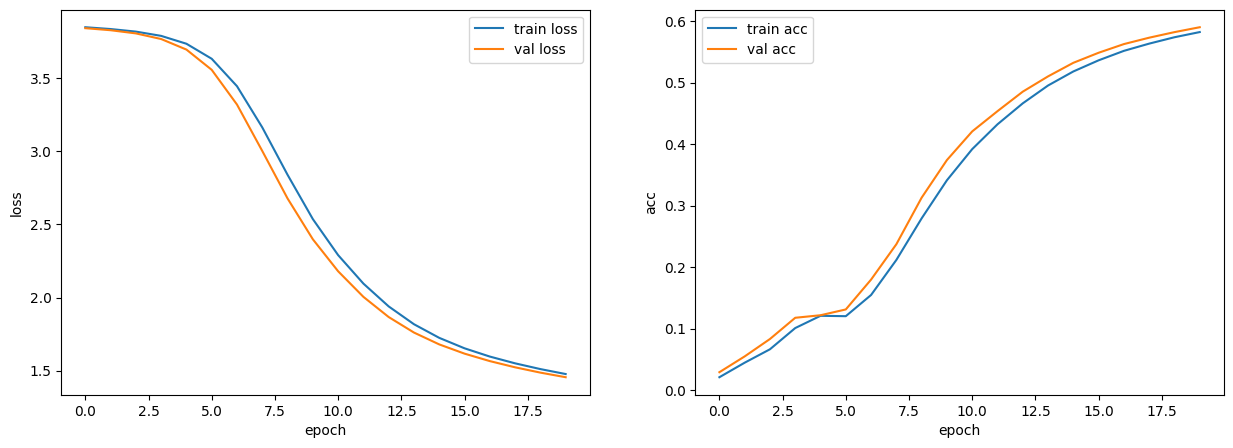

In [11]:
evaluate(model, loss_nn, optimizer_nn, 20)

Train loss: 0.3175, Val loss: 0.6652 | Train acc: 0.8775, Val acc: 0.8179: 100%|██████████| 20/20 [07:40<00:00, 23.05s/it]


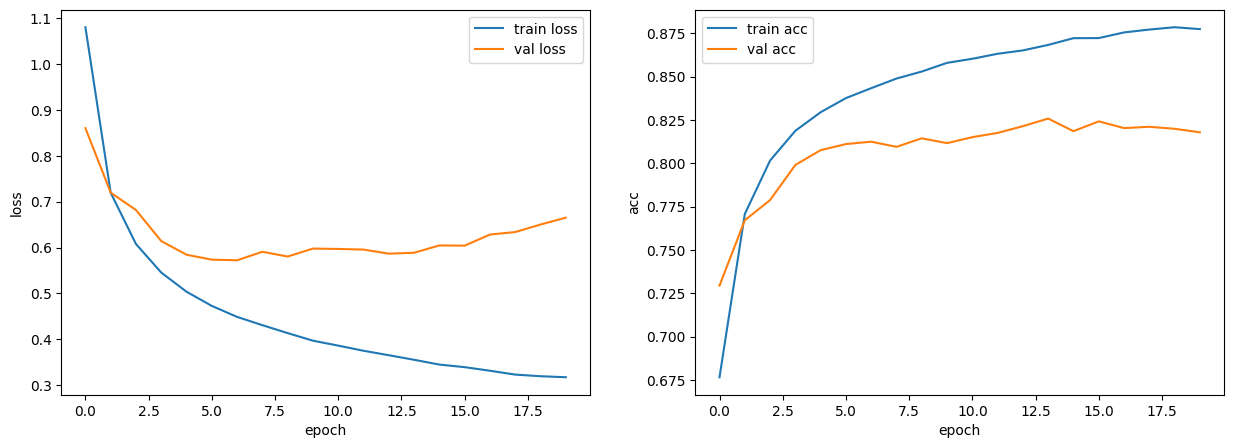

In [12]:
optimizer_nn = torch.optim.Adam(model.parameters(), lr=0.001)
evaluate(model, loss_nn, optimizer_nn, 20)

In [13]:
class BiggerNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerNN, self).__init__()
        self.input_stack = nn.Sequential(nn.Flatten(), nn.Linear(input_size, 512),
                                     nn.ReLU(), nn.Linear(512, 512),
                                     nn.ReLU(), nn.Linear(512, 256),
                                     nn.ReLU(), nn.Linear(256, 256),
                                     nn.ReLU(), nn.Linear(256, 128),
                                     nn.ReLU(), nn.Linear(128, 128),
                                     nn.ReLU(), nn.Linear(128, 64),
                                     nn.ReLU(), nn.Linear(64, 64),
                                     nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.input_stack(x)

model=BiggerNN(input_size=28*28, num_classes=47)
model=model.to(device)
print(model)

BiggerNN(
  (input_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=64, bias=True)
    (14): ReLU()
    (15): Linear(in_features=64, out_features=64, bias=True)
    (16): ReLU()
    (17): Linear(in_features=64, out_features=47, bias=True)
  )
)


Train loss: 0.2963, Val loss: 0.6162 | Train acc: 0.8923, Val acc: 0.8303: 100%|██████████| 20/20 [08:14<00:00, 24.73s/it]


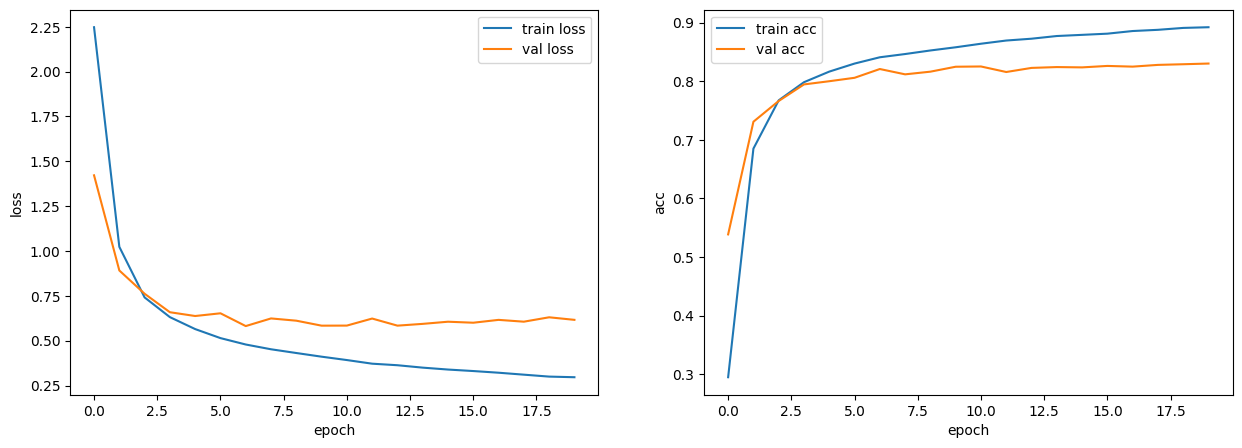

In [14]:
optimizer_nn = torch.optim.Adam(model.parameters(), lr=0.001)
evaluate(model, loss_nn, optimizer_nn, 20)

In [15]:
class BiggerBN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerBN, self).__init__()
        self.input_stack = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 512), nn.BatchNorm1d(512),
                                     nn.ReLU(), nn.Linear(512, 512), nn.BatchNorm1d(512),
                                     nn.ReLU(), nn.Linear(512, 256), nn.BatchNorm1d(256),
                                     nn.ReLU(), nn.Linear(256, 256), nn.BatchNorm1d(256),
                                     nn.ReLU(), nn.Linear(256, 128), nn.BatchNorm1d(128),
                                     nn.ReLU(), nn.Linear(128, 128), nn.BatchNorm1d(128),
                                     nn.ReLU(), nn.Linear(128, 128), nn.BatchNorm1d(128),
                                     nn.ReLU(), nn.Linear(128, 64), nn.BatchNorm1d(64),
                                     nn.ReLU(), nn.Linear(64, 64), nn.BatchNorm1d(64),
                                     nn.ReLU(), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.input_stack(x)

model=BiggerBN(input_size=28*28, num_classes=47)
model=model.to(device)
print(model)

BiggerBN(
  (input_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Linear(in_features=256, out_features=128, bias=True)
    (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Linear(in_features=128, out_features=128, bias=True)
    (17): 

Train loss: 0.1790, Val loss: 0.5830 | Train acc: 0.9301, Val acc: 0.8474: 100%|██████████| 20/20 [09:14<00:00, 27.70s/it]


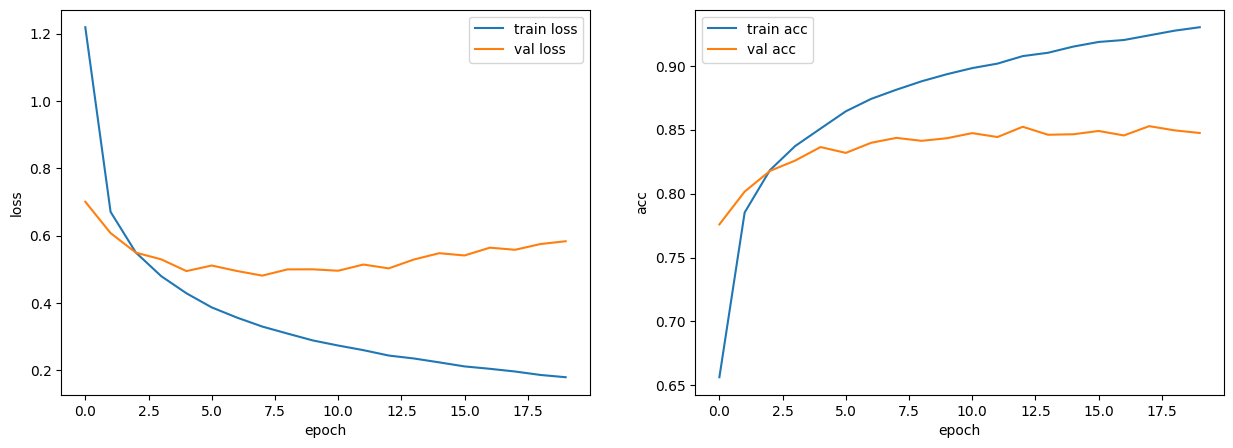

In [16]:
optimizer_nn = torch.optim.Adam(model.parameters(), lr=0.001)
evaluate(model, loss_nn, optimizer_nn, 20)

In [17]:
class BiggerDO(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BiggerDO, self).__init__()
        self.input_stack = nn.Sequential(
            nn.Flatten(), nn.Linear(28*28, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(512, 512), nn.BatchNorm1d(512),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(512, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 256), nn.BatchNorm1d(256),
            nn.ReLU(), nn.Dropout(0.15), nn.Linear(256, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.10), nn.Linear(128, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, 64), nn.BatchNorm1d(64),
            nn.ReLU(), nn.Dropout(0.05), nn.Linear(64, num_classes))

    def forward(self, x):
        return self.input_stack(x)

model=BiggerDO(input_size=28*28, num_classes=47)
model=model.to(device)
print(model)

BiggerDO(
  (input_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.15, inplace=False)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.15, inplace=False)
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.15, inplace=False)
    (13): Linear(in_features=256, out_features=256, bias=True)
    (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Dropout(p=0.15, inplace=False)
    (17): Linear(in_features=256, out_features=128, bias=True)
    (18): BatchNo

Train loss: 0.3469, Val loss: 0.4320 | Train acc: 0.8774, Val acc: 0.8591: 100%|██████████| 20/20 [09:27<00:00, 28.36s/it]


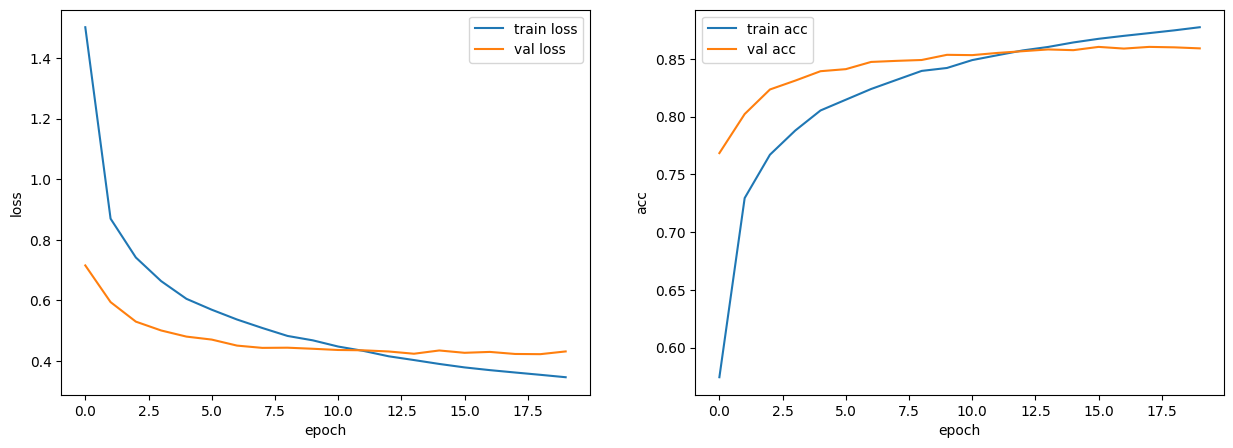

In [18]:
optimizer_nn = torch.optim.Adam(model.parameters(), lr=0.001)
evaluate(model, loss_nn, optimizer_nn, 20)